In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 32

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         2,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,616 (92.25 KB)

 Trainable params: 23,040 (90.00 KB)

 Non-trainable params: 576 (2.25 KB)

In [9]:
# Model checkpoint callback
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [11]:
# Model compilation
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [12]:
model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=256,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback, lr_scheduler]
)

Epoch 1/500
94/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2556 - loss: 2.7831
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.2654 - loss: 2.7515 - val_accuracy: 0.6325 - val_loss: 2.3968 - learning_rate: 0.0010
Epoch 2/500
97/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7709 - loss: 1.1049
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7717 - loss: 1.1015 - val_accuracy: 0.8621 - val_loss: 1.1902 - learning_rate: 0.0010
Epoch 3/500
85/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8785 - loss: 0.5980
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8801 - loss: 0.5890 - val_accuracy: 0.9230 - val_loss: 0.5050 - learning_rate: 0.0010
Epoch 4/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9123 - loss: 0.4121
Epoch 4: sav

In [13]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=256)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9926 - loss: 0.0304


In [14]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [15]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
[3.1197145e-05 7.4361458e-07 2.9678505e-08 2.2691521e-10 4.3849582e-09
 3.0421712e-10 2.4154147e-08 7.0243019e-08 2.8804197e-09 1.2777457e-07
 3.5787009e-09 1.9974882e-06 9.9919433e-09 5.9392601e-08 2.6748024e-09
 2.6464260e-08 6.3455130e-09 1.0292284e-08 1.9081654e-07 2.1234367e-11
 6.8584116e-10 2.5792508e-08 5.6237015e-09 7.7964418e-05 1.2264159e-07
 1.6550112e-08 1.8645147e-10 9.9988651e-01 4.0322232e-07 3.3803869e-07
 1.0269459e-08 2.7612749e-08]
27


# Confusion matrix

261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


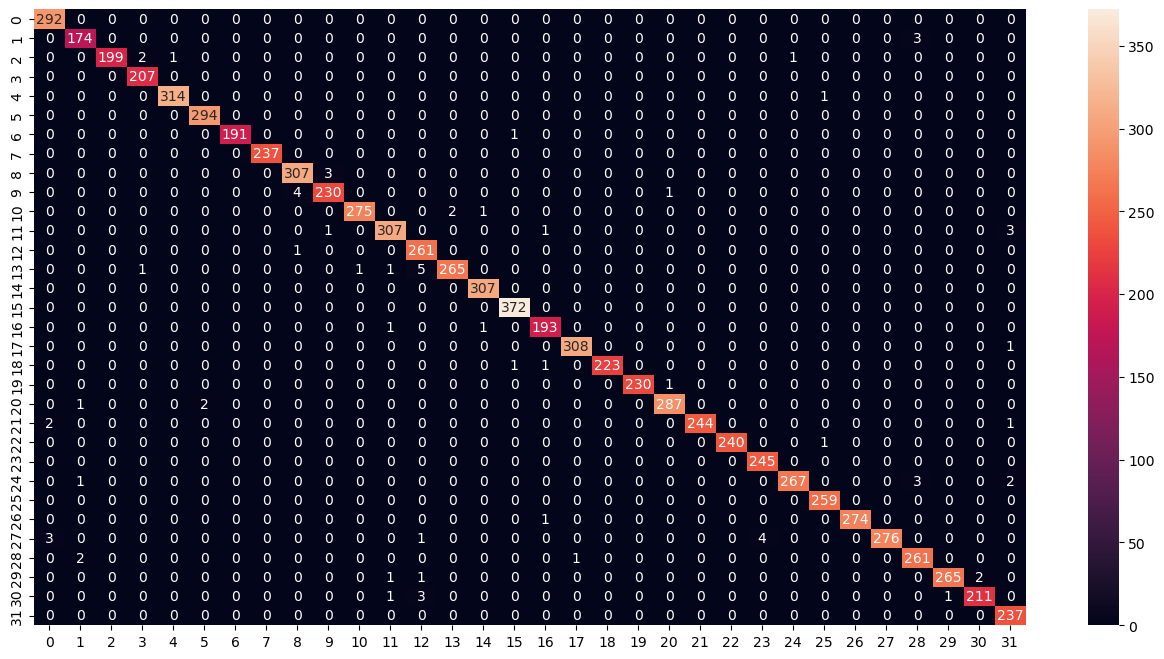

Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       292
           1       0.98      0.98      0.98       177
           2       1.00      0.98      0.99       203
           3       0.99      1.00      0.99       207
           4       1.00      1.00      1.00       315
           5       0.99      1.00      1.00       294
           6       1.00      0.99      1.00       192
           7       1.00      1.00      1.00       237
           8       0.98      0.99      0.99       310
           9       0.98      0.98      0.98       235
          10       1.00      0.99      0.99       278
          11       0.99      0.98      0.99       312
          12       0.96      1.00      0.98       262
          13       0.99      0.97      0.98       273
          14       0.99      1.00      1.00       307
          15       0.99      1.00      1.00       372
          16       0.98      0.99      0.99       195
     

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(16, 8))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [17]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [18]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\phoen\AppData\Local\Temp\tmp5lahric_\assets


INFO:tensorflow:Assets written to: C:\Users\phoen\AppData\Local\Temp\tmp5lahric_\assets


Saved artifact at 'C:\Users\phoen\AppData\Local\Temp\tmp5lahric_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 32), dtype=tf.float32, name=None)
Captures:
  2246076492752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2246093564496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2246094391440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2246094389328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2246094390288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2246094389904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2246094390864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2246094394128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2246123696208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2246123695824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2246094390672:

30672

# Inference test

In [19]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

c:\Users\phoen\anaconda3\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [20]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [21]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [22]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [23]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.99928233e-05 7.31628290e-07 2.90722131e-08 2.41386300e-10
 4.85579577e-09 3.09780701e-10 2.58039528e-08 7.28556557e-08
 2.79635848e-09 1.27103363e-07 3.67694919e-09 2.02668389e-06
 9.97396121e-09 6.04304589e-08 2.73827849e-09 2.74792757e-08
 6.34567732e-09 1.11111058e-08 1.89425919e-07 2.12542848e-11
 7.00791036e-10 2.62722200e-08 5.68308911e-09 8.37601692e-05
 1.23382108e-07 1.73343668e-08 1.85584201e-10 9.99881983e-01
 3.97130407e-07 3.44638948e-07 1.03945474e-08 2.76764229e-08]
27
